# Week 9 & 10 Exercise
## Name: Rohit Patil
### Course: DSC640 - Data Presentation & Visualization
### Exercise: 9 & 10 Assignment: TSA Complaints
### Due Date: 10/08/2025

***

## 1. Load the Datasets
Our first step is to load the four provided CSV datasets into pandas DataFrames. This will allow us to begin exploring and manipulating the data.

- `complaints_by_airport.csv`: Contains monthly complaint counts for each airport.
- `complaints_by_category.csv`: Contains monthly complaint counts broken down by the main category of the complaint.
- `complaints_by_subcategory.csv`: Contains monthly complaint counts at the most granular subcategory level. This file is large, so we load it in chunks to avoid memory issues.
- `iata-icao.csv`: A lookup file that contains airport metadata, including location information, which we will use to map complaints geographically.

In [3]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# Load the primary datasets
complaints_by_airport = pd.read_csv('tsa-complaint-data/complaints-by-airport.csv')
complaints_by_category = pd.read_csv('tsa-complaint-data/complaints-by-category.csv')
iata_icao = pd.read_csv('tsa-complaint-data/iata-icao.csv')

# The subcategory file is very large, so we process it in chunks to prevent memory errors.
# We read the CSV in segments (chunks) and then concatenate them into a single DataFrame.
subcategory_chunks = []
for chunk in pd.read_csv('tsa-complaint-data/complaints-by-subcategory.csv', chunksize=100000):
    subcategory_chunks.append(chunk)
complaints_by_subcategory = pd.concat(subcategory_chunks, axis=0)

## 2. Data Cleaning and Transformation
Before we can visualize the data, we need to clean and prepare it. This involves merging datasets to create a unified view, handling missing values, and renaming columns for clarity.

In [5]:
# For time-based analysis, we extract the year from the 'year_month' column and create a new 'year' column.
# This is done before the merge so the 'year' column is available in the merged DataFrame.
complaints_by_airport['year'] = pd.to_datetime(complaints_by_airport['year_month'], format='%Y-%m').dt.year
complaints_by_category['year'] = pd.to_datetime(complaints_by_category['year_month'], format='%Y-%m').dt.year

# To perform a geographic analysis, we merge the airport complaints data with the IATA/ICAO lookup file.
# The merge is performed on the airport's IATA code.
airport_complaints_merged = pd.merge(complaints_by_airport, iata_icao, left_on='airport', right_on='iata', how='left')

# The merge creates conflicting 'airport_x' (code) and 'airport_y' (name) columns. We rename them for clarity.
airport_complaints_merged.rename(columns={'airport_x': 'iata_code', 'airport_y': 'airport_name', 'region_name': 'state', 'country_code': 'country'}, inplace=True)

# After the merge, some airports may not have location data. We fill these missing values with 'Unknown'.
airport_complaints_merged.fillna({'state': 'Unknown', 'country': 'Unknown', 'airport_name': 'Unknown'}, inplace=True)

## 3. Data Visualization: Telling the Story with 10 Visuals

### Visualization 1: Choropleth Map of Total Complaints by State
**Why it was chosen:** A choropleth map provides an immediate, high-level overview of where complaints are concentrated across the United States. It is perfect for a leadership audience that needs to understand regional performance at a glance.

**What it does:** This map colors each state based on total TSA complaints. Darker shades indicate a higher volume of complaints, instantly drawing attention to problem areas.

**How it helps the call to action:** This visualization allows leadership to see that the issue of passenger complaints is a widespread, national problem and that certain states are clear hotspots. This justifies a national-level response (our proposed training program) and suggests where the pilot program could be most impactful.

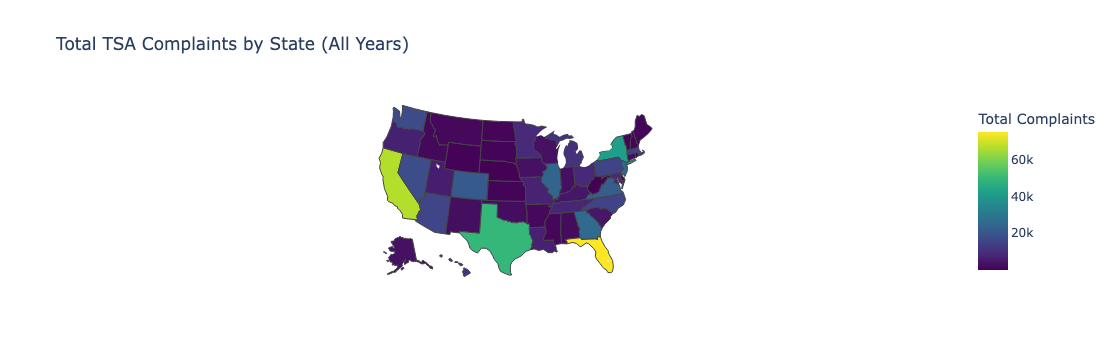

In [8]:
# We group the data by state and sum the complaint counts for all years.
us_complaints = airport_complaints_merged[airport_complaints_merged['country'] == 'US']
state_complaints = us_complaints.groupby('state')['count'].sum().reset_index()
state_complaints = state_complaints[state_complaints['state'] != 'Unknown']

# Mapping of state names to abbreviations
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

state_complaints['state_abbrev'] = state_complaints['state'].map(us_state_abbrev)

# Now plot using 'state_abbrev' instead of 'state'
fig = px.choropleth(state_complaints, 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    color='count', 
                    scope="usa",
                    title='Total TSA Complaints by State (All Years)',
                    color_continuous_scale="Viridis",
                    labels={'count':'Total Complaints'})

fig.show()

### Visualization 2: Monthly Trend of Total Complaints (Line Chart)
**Why it was chosen:** A line chart is the best tool for showing trends over time. It answers the question: 'Is the problem getting better or worse?'

**What it does:** This chart plots the monthly complaints received. This allows us to see the overall trajectory and any seasonal patterns (e.g., spikes during holiday travel seasons).

**How it helps the call to action:** A clear upward trend on this chart creates a powerful sense of urgency. It demonstrates to leadership that passenger dissatisfaction is not a static issue but a growing one that requires immediate intervention, strengthening the case for our proposed training program.

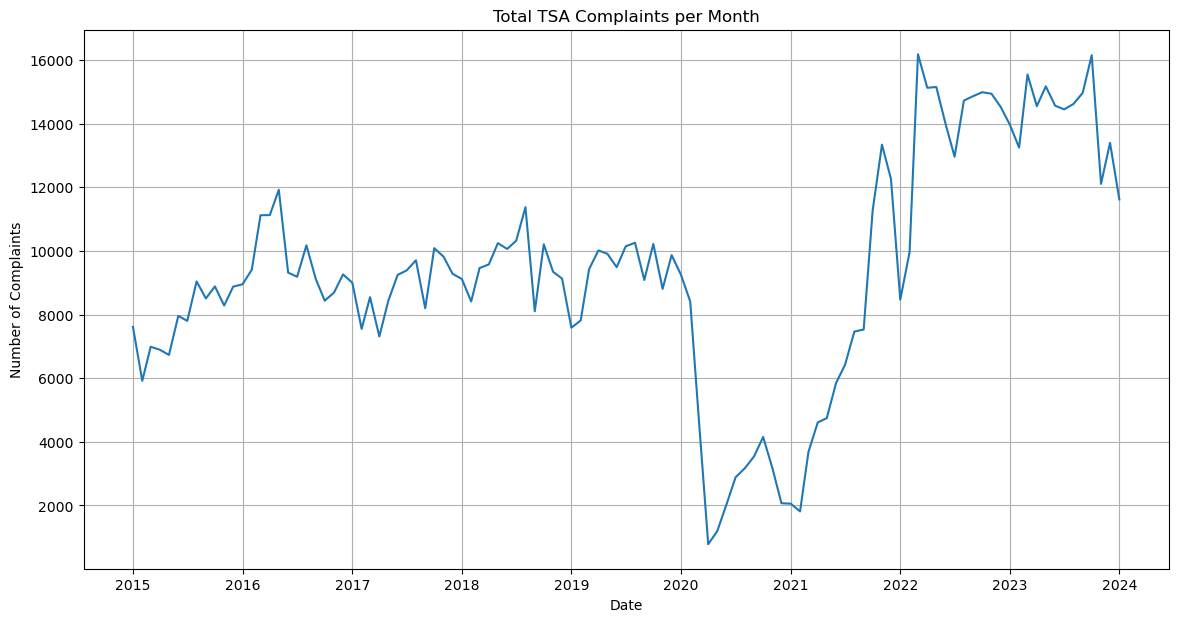

In [10]:
# Group by month and sum the counts to get a time series
monthly_complaints = complaints_by_airport.groupby('year_month')['count'].sum().reset_index()
monthly_complaints['year_month'] = pd.to_datetime(monthly_complaints['year_month'])

plt.figure(figsize=(14, 7))
sns.lineplot(x='year_month', y='count', data=monthly_complaints)
plt.title('Total TSA Complaints per Month')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.show()

### Visualization 3: Heatmap of Complaints by Category and Year
**Why it was chosen:** A heatmap shows the relationship between two categorical variables. It allows us to see how the composition of complaints has changed over time.

**What it does:** This heatmap displays the total number of complaints for each major category (y-axis) for each year (x-axis). The color intensity reveals which categories are growing sources of friction.

**How it helps the call to action:** If the heatmap shows a consistent darkening for categories like 'Passenger Courteousness,' it provides direct evidence that the *quality* of interactions is a growing problem. This directly supports our call to action for improved customer service training.

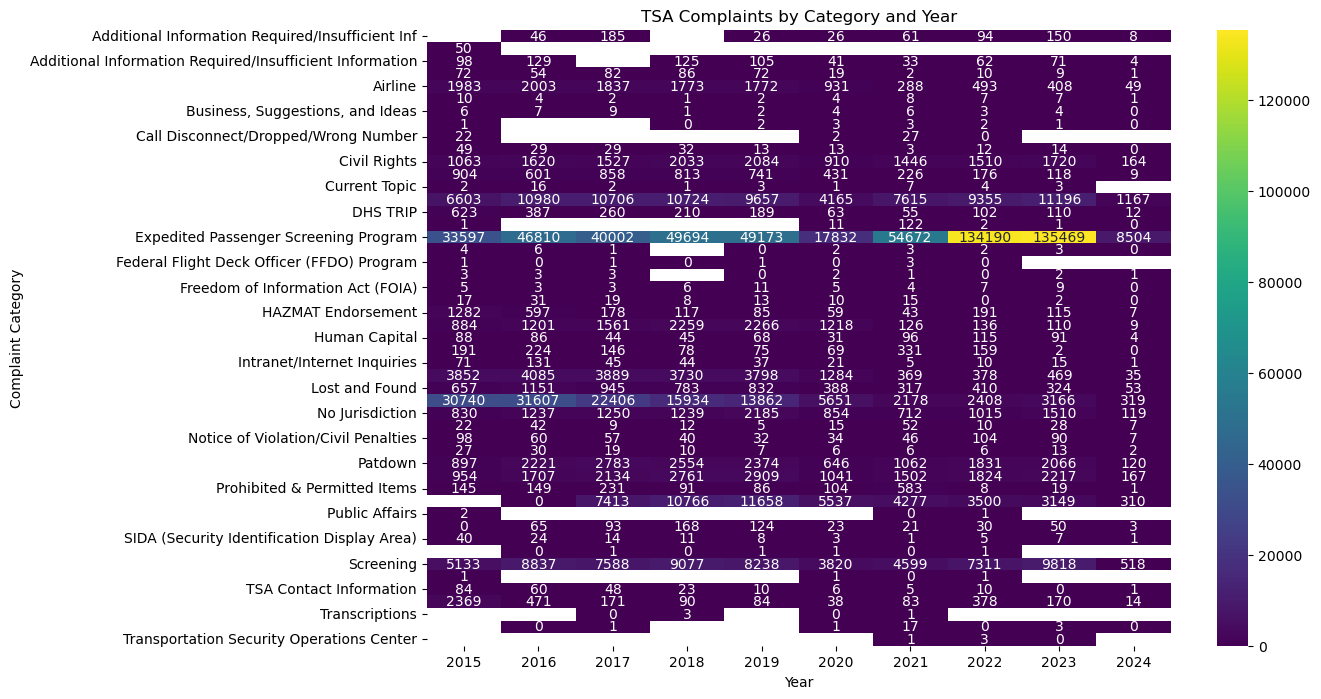

In [12]:
category_by_year = complaints_by_category.pivot_table(index='category', columns='year', values='count', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(category_by_year, cmap='viridis', annot=True, fmt='.0f')
plt.title('TSA Complaints by Category and Year')
plt.xlabel('Year')
plt.ylabel('Complaint Category')
plt.show()

### Visualization 4: Box Plot of Complaint Distribution by Year
**Why it was chosen:** A box plot shows the distribution and spread of data. It goes beyond simple averages to show each year's range, median, and potential outliers in complaint volumes.

**What it does:** This visualization shows a box plot for each year, representing the distribution of monthly complaint counts across all airports. We can see if the median number of complaints is rising.

**How it helps the call to action:** An upward trend in the median demonstrates that high complaint volumes are not just isolated incidents but are becoming the 'new normal' across the board. This worsening systemic issue creates urgency in our call for a new training initiative.

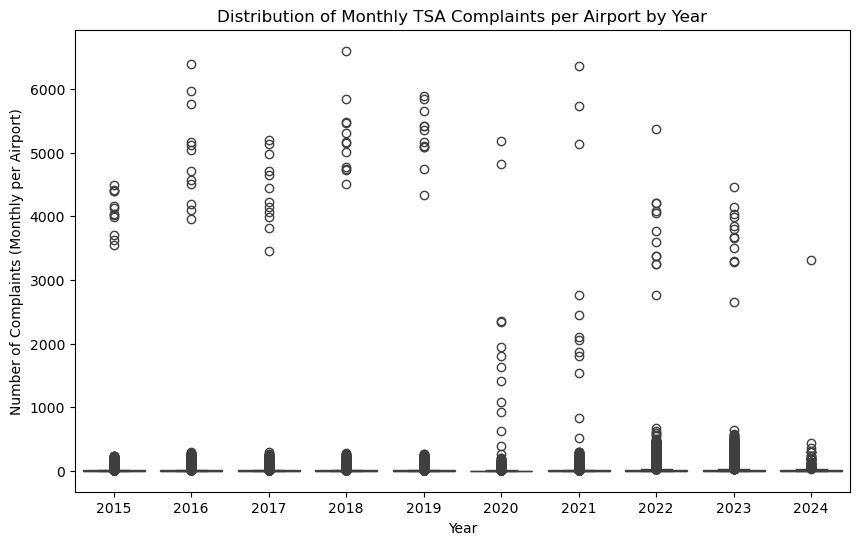

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='count', data=complaints_by_airport)
plt.title('Distribution of Monthly TSA Complaints per Airport by Year')
plt.xlabel('Year')
plt.ylabel('Number of Complaints (Monthly per Airport)')
plt.show()

### Visualization 5: Bar Chart of Top 10 Airports by Complaint Volume
**Why it was chosen:** A bar chart is highly effective for directly comparing. It clearly and immediately identifies the airports with the highest complaints.

**What it does:** This chart displays the top 10 airports ranked by their total number of complaints over all years.

**How it helps the call to action:** This visualization helps leadership identify which major hubs are the most significant sources of passenger friction. This allows us to suggest that the pilot program for our new training could be rolled out at these specific high-impact locations for the most immediate and measurable results.

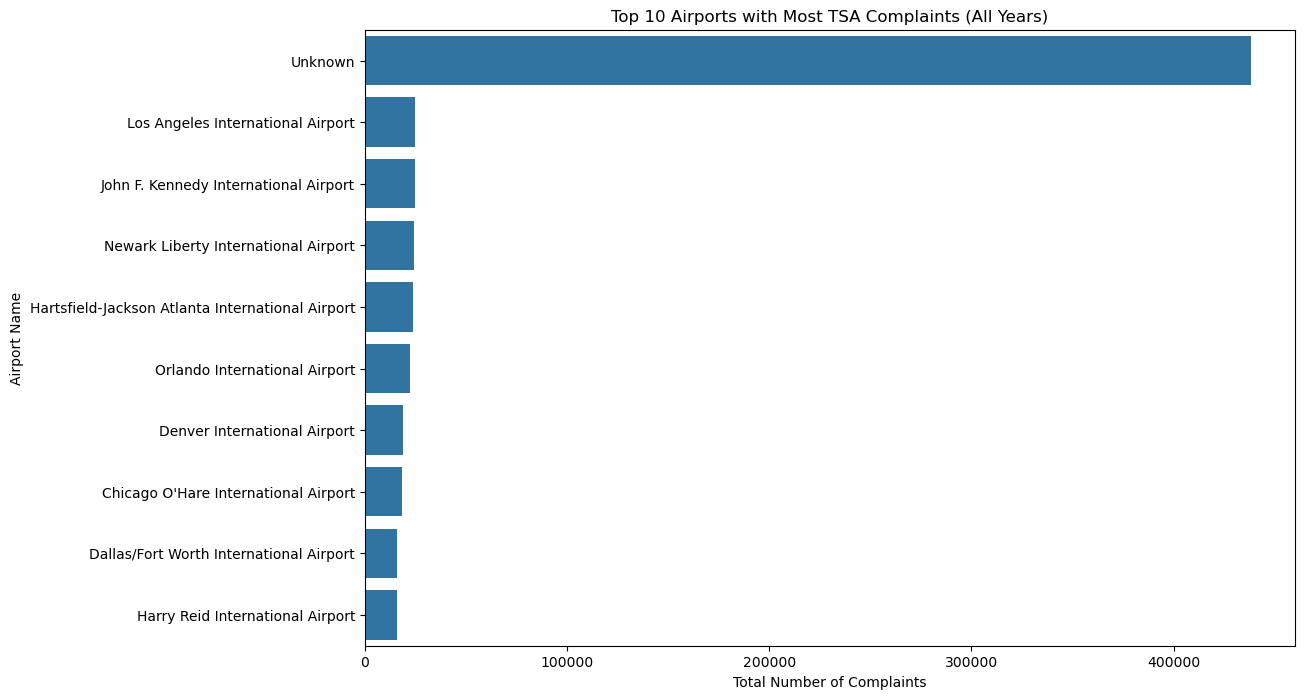

In [16]:
# FIX: Group by the renamed 'airport_name' column to get full names for the chart.
top_10_airports = airport_complaints_merged.groupby('airport_name')['count'].sum().nlargest(10).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='airport_name', data=top_10_airports, orient='h')
plt.title('Top 10 Airports with Most TSA Complaints (All Years)')
plt.xlabel('Total Number of Complaints')
plt.ylabel('Airport Name')
plt.show()

### Visualization 6: Complaint Categories Breakdown (Horizontal Bar Chart)
**Why it was chosen:** A horizontal bar chart is far superior to a pie chart for comparing proportions, especially with several categories. It avoids label overlap and makes it easy to rank categories.

**What it does:** This chart shows the total count of complaints for each major category, ordered from most to least common. It answers: 'What are the biggest drivers of complaints?'

**How it helps the call to action:** This visual clearly ranks problem areas. If 'Passenger Courteousness' and 'Screening Process' are at the top, it provides a powerful, simple visual that tells leadership exactly where to focus their improvement efforts. It validates that our proposed training addresses the most significant part of the problem.

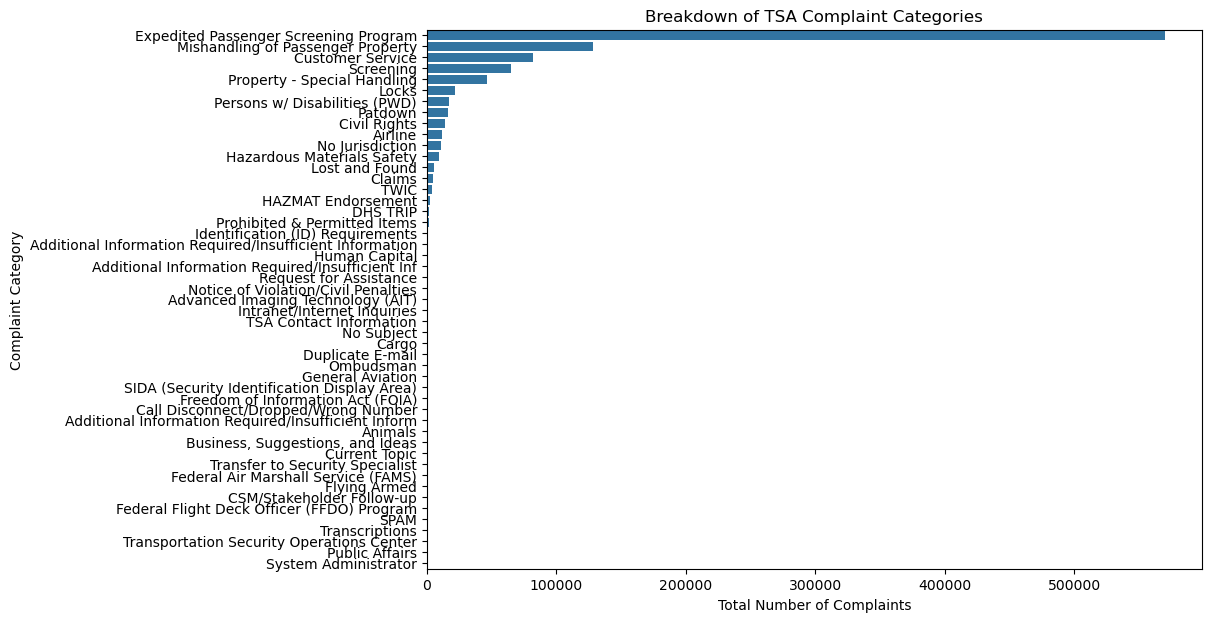

In [18]:
# FIX: Replaced the pie chart with a more readable horizontal bar chart.
category_totals = complaints_by_category.groupby('category')['count'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x=category_totals.values, y=category_totals.index, orient='h')
plt.title('Breakdown of TSA Complaint Categories')
plt.xlabel('Total Number of Complaints')
plt.ylabel('Complaint Category')
plt.show()

### Visualization 7: Deep Dive into the Top Complaint Category
**Why it was chosen:** After identifying the top complaint category, a deeper dive is necessary. This bar chart breaks that category into subcategories, moving from the 'what' to the 'why'.

**What it does:** This chart filters the data for the #1 complaint category (determined from the previous chart) and displays the counts for its most common subcategories. 

**How it helps the call to action:** This is a highly actionable visualization. If the top category is 'Screening Process,' and this chart shows the top subcategories are 'Consistency' and 'Clarity of Instructions,' it gives leadership concrete topics that the proposed training curriculum must address. It makes the solution feel targeted and specific.

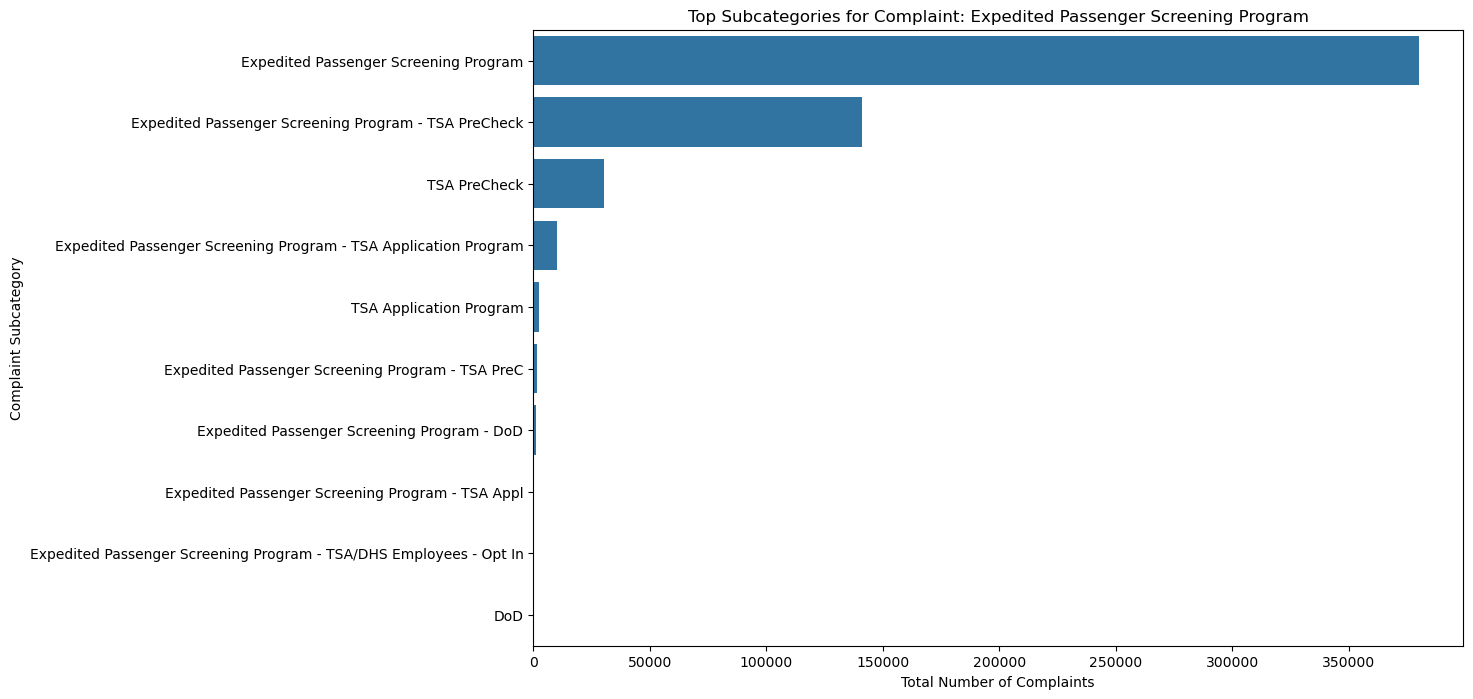

In [20]:
# NEW VISUALIZATION: Dynamically find the top complaint category
top_category = category_totals.index[0]

# Filter subcategory data for only the top category
top_cat_sub_data = complaints_by_subcategory[complaints_by_subcategory['category'] == top_category]
top_subcategories = top_cat_sub_data.groupby('subcategory')['count'].sum().nlargest(10).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_subcategories.values, y=top_subcategories.index, orient='h')
plt.title(f'Top Subcategories for Complaint: {top_category}')
plt.xlabel('Total Number of Complaints')
plt.ylabel('Complaint Subcategory')
plt.show()

### Visualization 8: Word Cloud of Complaint Subcategories
**Why it was chosen:** A word cloud provides a qualitative, high-impact look at the specific words and phrases passengers use in their complaints. It adds a human element to the quantitative data.

**What it does:** This visual displays the most frequent terms in the 'subcategory' field. The size of each word is proportional to its frequency.

**How it helps the call to action:** Seeing words like 'Rude,' 'Unprofessional,' or 'Confusing' displayed prominently gives leadership a direct, unfiltered view into the passenger's perspective. It moves beyond abstract categories to the language of frustration, making the need for improved interpersonal skills training undeniable and emotionally resonant.

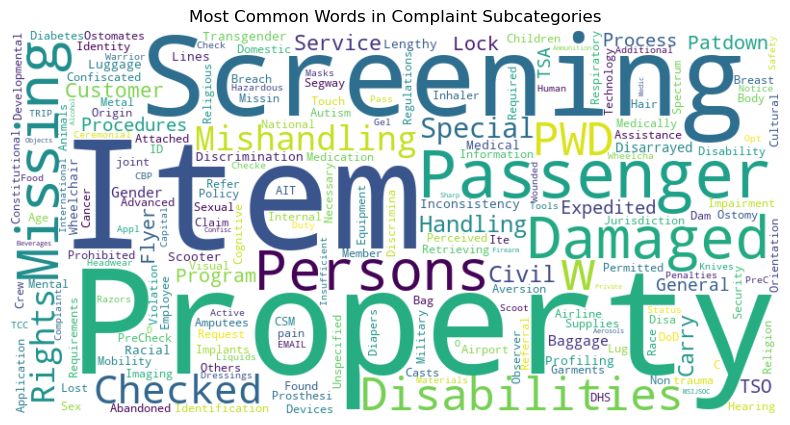

In [22]:
# We combine all non-null subcategory descriptions into a single string.
subcategory_text = ' '.join(complaints_by_subcategory['subcategory'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(subcategory_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Complaint Subcategories')
plt.show()

### Visualization 9: Top 10 Overall Complaint Subcategories
**Why it was chosen:** While understanding the top-level categories is essential, real change happens at the granular level. This chart identifies the most frequent, specific complaints across all categories.

**What it does:** This horizontal bar chart displays the top 10 most common complaint subcategories from the entire dataset, providing a clear rank-order of the most pressing specific issues.

**How it helps the call to action:** This visualization provides a particular, actionable list for leadership. It moves beyond broad categories like 'Screening Process' to pinpoint issues like 'Divestiture,' 'Staffing,' or 'Screening of Persons.' This allows for the creation of highly targeted training modules that directly address the most common points of friction.

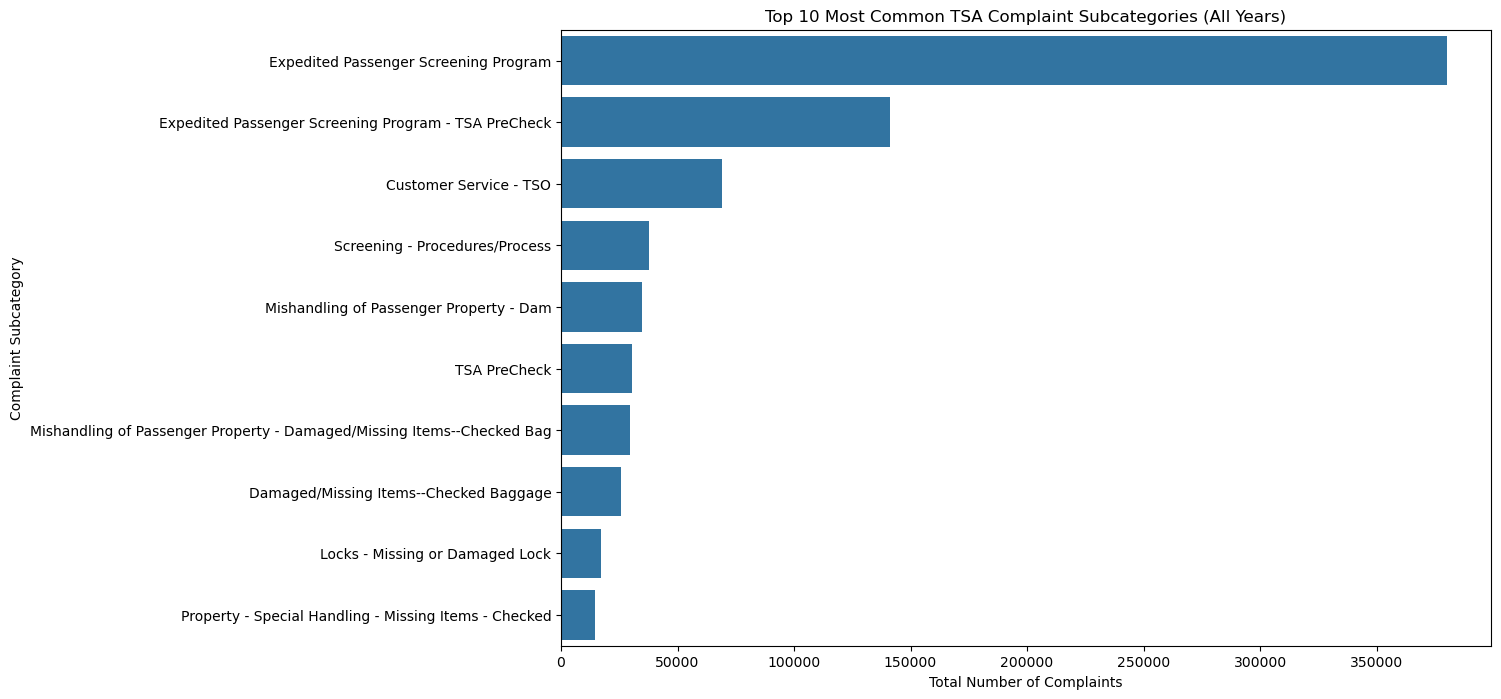

In [24]:
# Get the top 10 subcategories across all categories
top_10_subcategories = complaints_by_subcategory.groupby('subcategory')['count'].sum().nlargest(10).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='subcategory', data=top_10_subcategories, orient='h')
plt.title('Top 10 Most Common TSA Complaint Subcategories (All Years)')
plt.xlabel('Total Number of Complaints')
plt.ylabel('Complaint Subcategory')
plt.show()

### Visualization 10: Year-Over-Year Complaint Growth Rate

**Why it was chosen:** A raw trend line shows growth, but a percentage growth chart highlights the *rate* of change, which can be a more powerful metric for conveying urgency to leadership.

**What it does:** This bar chart calculates the total number of complaints each year and then displays the yearly percentage increase or decrease.

**How it helps the call to action:** A chart showing, for example, a 25% jump in complaints last year is a stark, undeniable signal that the problem is growing and accelerating. It frames the issue in business terms (growth rates) that leadership understands well and provides a powerful final argument for immediate investment in the proposed training program.

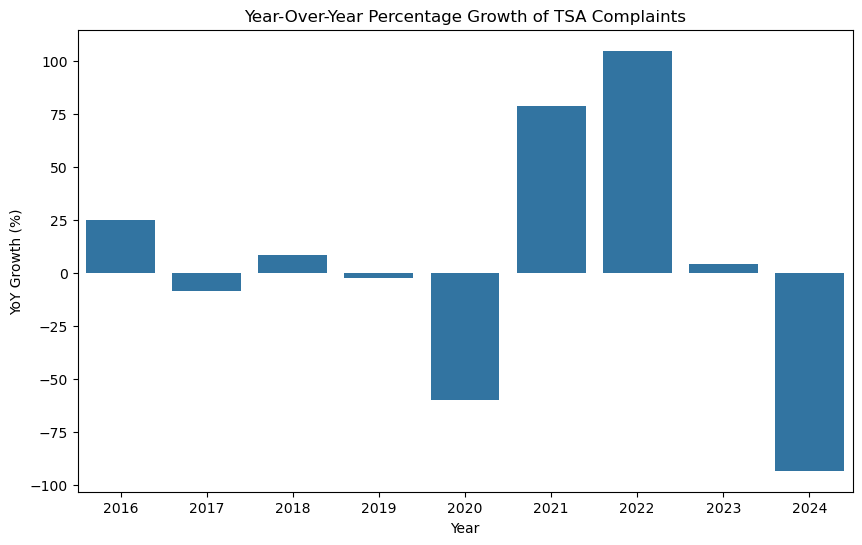

In [26]:
# Calculate total complaints per year from the airport data
yearly_complaints = complaints_by_airport.groupby('year')['count'].sum().reset_index()

# Calculate the year-over-year percentage change
yearly_complaints['yoy_growth'] = yearly_complaints['count'].pct_change() * 100

# Plot the growth rate
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='yoy_growth', data=yearly_complaints.dropna()) # Drop first year since it has no growth value
plt.title('Year-Over-Year Percentage Growth of TSA Complaints')
plt.xlabel('Year')
plt.ylabel('YoY Growth (%)')
plt.show()